# New LSTM Design Pt 2

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../')
import mne
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info

plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100)
fwd = create_forward_model(sampling="ico2", info=info)
leadfield = fwd["sol"]["data"]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


# Simulate

## defs

In [3]:
import numpy as np
import tensorflow as tf
import mne
import tensorflow.keras.backend as K

def prep_data(sim):
    X = np.squeeze(np.stack([eeg.average().data for eeg in sim.eeg_data]))
    y = np.squeeze(np.stack([src.data for src in sim.source_data]))
    for i, (x_sample, y_sample) in enumerate(zip(X, y)):
        # X[i] = np.stack([(x - np.mean(x)) / np.std(x) for x in x_sample.T], axis=0).T
        # y[i] = np.stack([ y / np.max(abs(y)) for y in y_sample.T], axis=0).T

        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] /= X[i].std()
        y[i] /= np.max(abs(y[i]))

        
    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    
    return X, y

def sparsity(y_true, y_pred):
    return K.mean(K.square(y_pred)) / K.max(K.square(y_pred))


def custom_loss():
    def loss(y_true, y_pred):
        loss1 = tf.keras.losses.CosineSimilarity()(y_true, y_pred)
        loss2 = sparsity(None, y_pred)
        return loss1 + loss2 * 1e-3
    return loss

from esinet.evaluate import auc_metric, eval_auc, eval_nmse, eval_mean_localization_error

def eval(y_true, y_hat):
    n_samples = y_true.shape[0]
    n_time = y_true.shape[1]
    aucs = np.zeros((n_samples, n_time))
    mles = np.zeros((n_samples, n_time))
    nmses = np.zeros((n_samples, n_time))
    for i in range(n_samples):
        for j in range(n_time):
            aucs[i,j] = np.mean(eval_auc(y_true[i,j], y_hat[i,j], pos))
            nmses[i,j] = eval_nmse(y_true[i,j], y_hat[i,j])
            mles[i,j] = eval_mean_localization_error(y_true[i,j], y_hat[i,j], pos)

    return aucs, nmses, mles

def threshold_activation(x):
    return tf.cast(x > 0.5, dtype=tf.float32)

def consistency(x):
    # error = K.mean(tf.experimental.numpy.diff(K.abs(x), axis=1))
    error = K.mean(K.abs(x[:,1:])-K.abs(x[:,:-1]))
    # error = K.mean(K.abs(x[:,1:]-x[:,:-1]))
    # print("error: ", error)
    return error

class Compressor:
    ''' Compression using Graph Fourier Transform
    '''
    def __init__(self):
        pass
    def fit(self, fwd, k=600):
        A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
        D = np.diag(A.sum(axis=0))
        L = D-A
        U, s, V = np.linalg.svd(L)

        self.U = U[:, -k:]
        self.s = s[-k:]
        self.V = V[:, -k:]
        return self
        
    def encode(self, X):
        ''' Encodes a true signal X
        Parameters
        ----------
        X : numpy.ndarray
            True signal
        
        Return
        ------
        X_comp : numpy.ndarray
            Compressed signal
        '''
        X_comp = self.U.T @ X

        return X_comp

    def decode(self, X_comp):
        ''' Decodes a compressed signal X

        Parameters
        ----------
        X : numpy.ndarray
            Compressed signal
        
        Return
        ------
        X_unfold : numpy.ndarray
            Decoded signal
        '''
        X_unfold = self.U @ X_comp
        return X_unfold


def generate_batches(batch_size, epochs=30, n_max=1000, settings=None):
    if settings is None:
        settings=dict(duration_of_trial=0.20, extents=(1,40), 
                      number_of_sources=(1,15), target_snr=1)

    n_samples = int(n_max - (n_max % batch_size))
    n_batches = int(n_samples / batch_size)
    print(n_samples, n_batches)
    while True:
        sim = Simulation(fwd, info, settings=settings, verbose=0).simulate(n_samples=n_samples)
        X, y = prep_data(sim)

        # yield X, y
        for _ in range(epochs):
            for i in range(n_batches-1):
                X_batch = X[i*batch_size:(i+1)*batch_size]
                y_batch = y[i*batch_size:(i+1)*batch_size]
            
        
                yield X_batch, y_batch
gen = generate_batches(8)

# TIME for better noise estimation

## Simulate

In [39]:
n_samples = 5000
# settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=(1, 15), method="noise", beta_source=4)
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=0.5)

sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)

Simulating data based on sparse patches.


100%|██████████| 5000/5000 [01:02<00:00, 80.30it/s]


## Craft noise-denoise Data

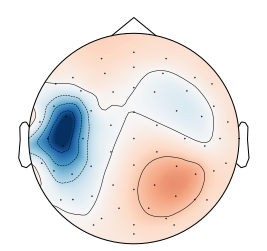

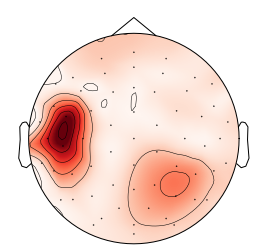

(<matplotlib.image.AxesImage at 0x23091e11bb0>,
 <matplotlib.contour.QuadContourSet at 0x23090c28e50>)

In [41]:
X_noiseless = np.stack([leadfield @ yy.T for yy in y], axis=0)
X_noiseless = np.swapaxes(X_noiseless, 1,2)
for i in range(X_noiseless.shape[0]):
    for j in range(X_noiseless.shape[1]):
        X_noiseless[i,j] -= X_noiseless[i,j].mean()
    X_noiseless[i,j] /= X_noiseless[i,j].std()
        

i = 2
j = 12
plt.figure()
mne.viz.plot_topomap(X[i,j,:], info)

plt.figure()
mne.viz.plot_topomap(X_noiseless[i,j,:], info)

# plt.figure()
# mne.viz.plot_topomap(abs(X_noiseless[i,j,:]), info)


## Build models

In [46]:
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Conv2D, Reshape, Flatten, BatchNormalization
from tensorflow.keras import backend as K
import tensorflow as tf

n_channels, _ = leadfield.shape
n_dipoles = y.shape[-1]

loss = tf.keras.losses.CosineSimilarity()
n_dense_units = 100
n_lstm_units = 25
activation_function = "tanh"
epochs = 30
batch_size = 8

#=========================================================#
# FC
# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# fc1 = TimeDistributed(Dense(n_dense_units, 
#             activation=activation_function), 
#             name='FC1')(inputs)
# out = TimeDistributed(Dense(n_channels, activation="tanh"))(fc1)

# model = tf.keras.Model(inputs=inputs, outputs=out, name='FC')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# LSTM
inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = Bidirectional(LSTM(n_lstm_units, return_sequences=True, name='LSTM1'))(inputs)
# fc1 = Bidirectional(LSTM(n_lstm_units, return_sequences=True, name='LSTM2'))(fc1)

out = TimeDistributed(Dense(n_channels, activation="tanh"))(fc1)


model = tf.keras.Model(inputs=inputs, outputs=out, name='LSTM')
model.compile(loss=loss, optimizer="adam", metrics=[loss,])
model.summary()
model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# Encoder-Decoder

# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# encoder_outputs, state_h, state_c = LSTM(n_lstm_units, return_state=True)(inputs)

# decoder_LSTM = LSTM(n_lstm_units, return_state=True, return_sequences=True)   
# decoder_outputs, _, _ = decoder_LSTM(inputs, initial_state=[state_h, state_c])
# outputs = TimeDistributed(Dense(n_channels, activation='tanh'))(decoder_outputs)

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Encoder-Decoder')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# CNN
# n_filters = 64
# inputs = tf.keras.Input(shape=(20, n_channels, 1), name='Input')

# cnn = Conv2D(n_filters, (3, 3), activation="relu")(inputs)
# cnn = BatchNormalization()(cnn)

# cnn = Conv2D(n_filters, (3, 3), activation="relu")(cnn)
# cnn = BatchNormalization()(cnn)

# cnn = Conv2D(n_filters, (3, 3), activation="relu")(cnn)
# cnn = BatchNormalization()(cnn)

# cnn = Conv2D(n_filters, (3, 3), activation="relu")(cnn)
# cnn = BatchNormalization()(cnn)

# cnn = Flatten()(cnn)
# cnn = Dense(n_channels*20, activation="tanh")(cnn)

# out = Reshape((20, n_channels, 1))(cnn)


# model = tf.keras.Model(inputs=inputs, outputs=out, name='CNN')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X[:, :, :, np.newaxis], X_noiseless[:, :, :, np.newaxis], epochs=epochs, batch_size=batch_size, validation_split=0.15)


Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 61)]   0           []                               
                                                                                                  
 bidirectional_5 (Bidirectional  (None, None, 50)    17400       ['Input[0][0]']                  
 )                                                                                                
                                                                                                  
 time_distributed_8 (TimeDistri  (None, None, 61)    3111        ['bidirectional_5[0][0]']        
 buted)                                                                                           
                                                                                               

## Test

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 51.42it/s]


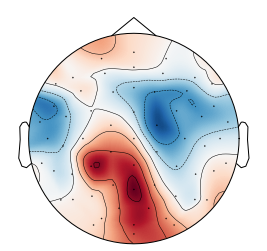

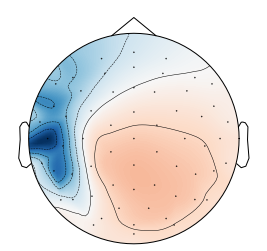

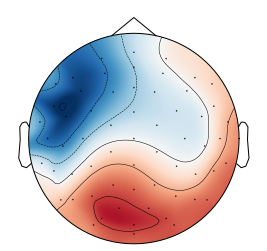

(<matplotlib.image.AxesImage at 0x232a3348f10>,
 <matplotlib.contour.QuadContourSet at 0x232a3359250>)

In [50]:
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=0.5)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=2)
X_test, y_test = prep_data(sim_test)

X_noiseless_test = np.stack([leadfield @ yy.T for yy in y_test], axis=0)
X_noiseless_test = np.swapaxes(X_noiseless_test, 1,2)
for i in range(X_noiseless_test.shape[0]):
    for j in range(X_noiseless_test.shape[1]):
        X_noiseless_test[i,j] -= X_noiseless_test[i,j].mean()
    X_noiseless_test[i,j] /= X_noiseless_test[i,j].std()
        

i = 0
j = 10
plt.figure()
mne.viz.plot_topomap(X_test[i,j,:], info)

plt.figure()
mne.viz.plot_topomap(X_noiseless_test[i,j,:], info)


# from copy import deepcopy
# X_test_surr = deepcopy(X_test)
# X_test_surr[0, j, :] += np.random.randn(n_channels)*1
# X_pred = model.predict(X_test_surr)

# plt.figure()
# mne.viz.plot_topomap(X_test_surr[i,j,:], info)


X_pred = model.predict(X_test)
plt.figure()
mne.viz.plot_topomap(X_pred[i,j,:], info)


# Time for better Noise estimation 2

## Simulate

In [52]:
n_samples = 5000
# settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=(1, 15), method="noise", beta_source=4)
settings = dict(duration_of_trial=0.10, extents=(1,40), number_of_sources=(1,15), target_snr=1, beta_noise=(0,2))

sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)

Simulating data based on sparse patches.


100%|██████████| 5000/5000 [00:34<00:00, 146.21it/s]


## Craft noise-denoise Data

(5000, 61, 10)
(5000, 10, 61)


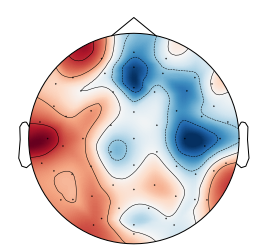

C:\Users\Lukas\AppData\Local\Temp/ipykernel_11420/1407026434.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


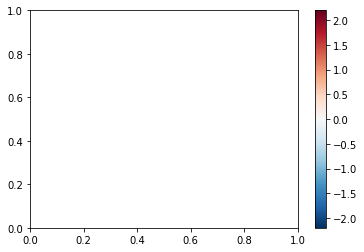

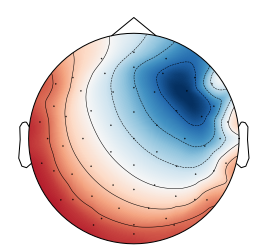

(5000, 1, 61)


C:\Users\Lukas\AppData\Local\Temp/ipykernel_11420/1407026434.py:19: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


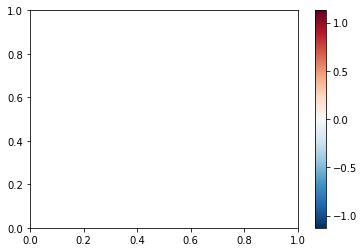

In [53]:
X_noiseless = np.stack([leadfield @ yy.T for yy in y], axis=0)
print(X_noiseless.shape)
X_noiseless = np.swapaxes(X_noiseless, 1,2)
print(X_noiseless.shape)
for i in range(X_noiseless.shape[0]):
    for j in range(X_noiseless.shape[1]):
        X_noiseless[i,j] -= X_noiseless[i,j].mean()
    X_noiseless[i,] /= X_noiseless[i,].std()
        

i = 1
j = -1
plt.figure()
im, _ = mne.viz.plot_topomap(X[i,j,:], info)
plt.colorbar(im)

plt.figure()
im, _ = mne.viz.plot_topomap(X_noiseless[i,j,:], info)
plt.colorbar(im)

X_noiseless = X_noiseless[:, -1, :]
X_noiseless = X_noiseless[:, np.newaxis]
print(X_noiseless.shape)

## Build models

In [120]:
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Conv2D, Reshape, Flatten, BatchNormalization, concatenate, GRU, add, MultiHeadAttention
loss = "cosine_similarity"
inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# fc1 = TimeDistributed(Dense(n_channels, 
#             activation=activation_function), 
#             name='FC1')(inputs)
attention = MultiHeadAttention(num_heads=8, key_dim=64, )(inputs, inputs)
fc1 = TimeDistributed(Dense(n_channels, 
            activation=activation_function), 
            name='FC1')(attention)

attention = MultiHeadAttention(num_heads=8, key_dim=64, )(fc1, fc1)



# fc1 = TimeDistributed(Dense(n_dense_units, 
#             activation=activation_function), 
#             name='FC1')(attention)
# out = TimeDistributed(Dense(n_channels, activation="tanh"))(fc1)

model = tf.keras.Model(inputs=inputs, outputs=attention, name='FC')

model.compile(loss=loss, optimizer="adam")
model.summary()
model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# model.fit(X[:, -1, :][:, np.newaxis], X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "FC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 61)]   0           []                               
                                                                                                  
 multi_head_attention_25 (Multi  (None, None, 61)    126525      ['Input[0][0]',                  
 HeadAttention)                                                   'Input[0][0]']                  
                                                                                                  
 FC1 (TimeDistributed)          (None, None, 61)     3782        ['multi_head_attention_25[0][0]']
                                                                                                  
 multi_head_attention_26 (Multi  (None, None, 61)    126525      ['FC1[0][0]',                   

In [93]:
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Conv2D, Reshape, Flatten, BatchNormalization, concatenate, GRU, add
from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')
n_channels, _ = leadfield.shape
n_dipoles = y.shape[-1]

loss = "huber"  # tf.keras.losses.CosineSimilarity(axis=-2)
n_dense_units = 100
n_lstm_units = 100
activation_function = "elu"
epochs = 30
batch_size = 4

#=========================================================#
# FC
# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# fc1 = TimeDistributed(Dense(n_dense_units, 
#             activation=activation_function), 
#             name='FC1')(inputs)
# out = TimeDistributed(Dense(n_channels, activation="tanh"))(fc1)

# model = tf.keras.Model(inputs=inputs, outputs=out, name='FC')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# # model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# model.fit(X[:, -1, :][:, np.newaxis], X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# U-Net FC 
inputs = tf.keras.Input(shape=(10, n_channels), name='Input')
flat = Flatten()(inputs)
fc_down_1 = Dense(n_channels, 
            activation=activation_function, 
            name='FC1')(flat)

fc_down_2 = Dense(int(n_channels/2), 
            activation=activation_function, 
            name='FC2')(fc_down_1)

fc_down_3 = Dense(int(n_channels/3), 
            activation=activation_function, 
            name='FC3')(fc_down_2)

fc_down_4 = Dense(int(n_channels/3), 
            activation=activation_function, 
            name='FC4')(fc_down_3)

skip_1 = add([fc_down_3, fc_down_4])


fc_up_1 = Dense(int(n_channels/2), 
            activation=activation_function, 
            name='FC5')(skip_1)

skip_2 = add([fc_down_2, fc_up_1])


fc_up_2 = Dense(n_channels, 
            activation=activation_function, 
            name='FC6')(skip_2)
            
skip_3 = add([fc_down_1, fc_up_2])


model = tf.keras.Model(inputs=inputs, outputs=skip_3, name='U-Net')

model.compile(loss=loss, optimizer="adam")
model.summary()
model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# model.fit(X[:, -1, :][:, np.newaxis], X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# FC-FullTime
# inputs = tf.keras.Input(shape=(10, n_channels), name='Input')
# fc1 = TimeDistributed(Dense(n_dense_units, 
#             activation=activation_function,
#             name='FC1'))(inputs)

# fc1 = Flatten()(fc1)
# fc1 = Dense(n_channels, activation=activation_function)(fc1)

# out = Dense(n_channels, activation="linear")(fc1)

# model = tf.keras.Model(inputs=inputs, outputs=out, name='FC-Fulltime')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# LSTM
# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# fc1 = GRU(n_lstm_units, return_sequences=False, name='LSTM1')(inputs)
# # fc1 = LSTM(n_lstm_units, return_sequences=False, name='LSTM2')(fc1)

# out = Dense(n_channels, activation="linear")(fc1)
# # out = LSTM(n_channels, return_sequences=False, name='LSTM2')(fc1)


# model = tf.keras.Model(inputs=inputs, outputs=out, name='LSTM')
# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# # model.fit(X[:, -1, :][:, np.newaxis], X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)


#=========================================================#
# Encoder-Decoder

# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# encoder_outputs, state_h, state_c = LSTM(n_lstm_units, return_state=True)(inputs)

# decoder_LSTM = LSTM(n_lstm_units, return_state=True, return_sequences=True)   
# decoder_outputs, _, _ = decoder_LSTM(inputs, initial_state=[state_h, state_c])


# outputs = Dense(n_channels, activation='linear')(decoder_outputs)

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Encoder-Decoder')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# # model.fit(X[:, -1, :][:, np.newaxis], X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# Encoder-Decoder 2

# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

# fc1 = Dense(n_dense_units, 
#             activation=activation_function, 
#             name='FC1')(inputs)

# encoder_outputs, state_h, state_c = LSTM(n_lstm_units, return_state=True)(inputs)

# decoder_LSTM = LSTM(n_lstm_units, return_state=True, return_sequences=True)   
# decoder_outputs, _, _ = decoder_LSTM(inputs, initial_state=[state_h, state_c])

# # outputs = Dense(n_channels, activation='tanh')(decoder_outputs)

# cat = concatenate([decoder_outputs, fc1, inputs])
# outputs = Dense(n_channels, activation="tanh")(cat)

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Encoder-Decoder-2')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X, X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)
# # model.fit(X[:, -1, :][:, np.newaxis], X_noiseless, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# CNN
# n_filters = 64
# inputs = tf.keras.Input(shape=(20, n_channels, 1), name='Input')

# cnn = Conv2D(n_filters, (3, n_channels), activation="linear")(inputs)
# # cnn = BatchNormalization()(cnn)

# # cnn = Conv2D(n_filters, (3, 3), activation="relu")(cnn)
# # cnn = BatchNormalization()(cnn)

# # cnn = Conv2D(n_filters, (3, 3), activation="relu")(cnn)
# # cnn = BatchNormalization()(cnn)

# # cnn = Conv2D(n_filters, (3, 3), activation="relu")(cnn)
# # cnn = BatchNormalization()(cnn)

# cnn = Flatten()(cnn)
# out = Dense(n_channels, activation="linear")(cnn)



# model = tf.keras.Model(inputs=inputs, outputs=out, name='CNN')

# model.compile(loss=loss, optimizer="adam")
# model.summary()
# model.fit(X[:, :, :, np.newaxis], X_noiseless[:, :, :], epochs=epochs, batch_size=batch_size, validation_split=0.15)


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 10, 61)]     0           []                               
                                                                                                  
 flatten_24 (Flatten)           (None, 610)          0           ['Input[0][0]']                  
                                                                                                  
 FC1 (Dense)                    (None, 61)           37271       ['flatten_24[0][0]']             
                                                                                                  
 FC2 (Dense)                    (None, 30)           1860        ['FC1[0][0]']                    
                                                                                              

## Test

Simulating data based on sparse patches.


100%|██████████| 100/100 [00:00<00:00, 149.47it/s]


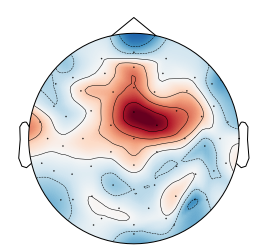

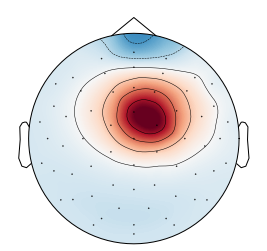

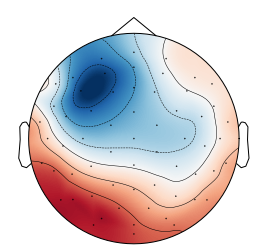

Total: -0.13892553746700287
Last: 0.48529383540153503


In [118]:
settings = dict(duration_of_trial=0.1, extents=(1,40), number_of_sources=(1,15), beta_noise=(0,2), target_snr=1)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=100)
X_test, y_test = prep_data(sim_test)

X_noiseless_test = np.stack([leadfield @ yy.T for yy in y_test], axis=0)
X_noiseless_test = np.swapaxes(X_noiseless_test, 1,2)
for i in range(X_noiseless_test.shape[0]):
    for j in range(X_noiseless_test.shape[1]):
        X_noiseless_test[i,j] -= X_noiseless_test[i,j].mean()
    X_noiseless_test[i,j] /= X_noiseless_test[i,j].std()
        
X_noiseless_test = X_noiseless_test[:, -1, :]
X_noiseless_test = X_noiseless_test[:, np.newaxis]

i = 0
j = -1
plt.figure()
mne.viz.plot_topomap(X_test[i,j,:], info)

plt.figure()
mne.viz.plot_topomap(X_noiseless_test[i,0,:], info)


# X_pred = model.predict(X_test.reshape(100, 20*61)).reshape(100, 61)
X_pred = model.predict(X_test)
if len(X_pred.shape)>2:
    cs_total = tf.keras.losses.CosineSimilarity()(tf.cast(X_test[:, -1], dtype=tf.float32), tf.cast(X_pred[:,-1], dtype=tf.float32)).numpy()
    X_pred = X_pred[i, -1]
else:
    cs_total = tf.keras.losses.CosineSimilarity()(tf.cast(X_test[:, -1], dtype=tf.float32), tf.cast(X_pred[:,], dtype=tf.float32)).numpy()
    X_pred = X_pred[i]

plt.figure()
mne.viz.plot_topomap(X_pred, info)
cs = tf.keras.losses.CosineSimilarity()(tf.cast(X_test[0, -1], dtype=tf.float32), tf.cast(X_pred, dtype=tf.float32)).numpy()
print(f"Total: {cs_total}\nLast: {cs}")

# Strong Temporal Prior

## Simulate

In [171]:
n_samples = 5000
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=1, target_snr=(0.5, 3), beta_noise=(0,2), source_time_course="pulse")

sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)

Simulating data based on sparse patches.


100%|██████████| 5000/5000 [01:17<00:00, 64.79it/s]


## Show sample

No projector specified for this dataset. Please consider the method self.add_proj.


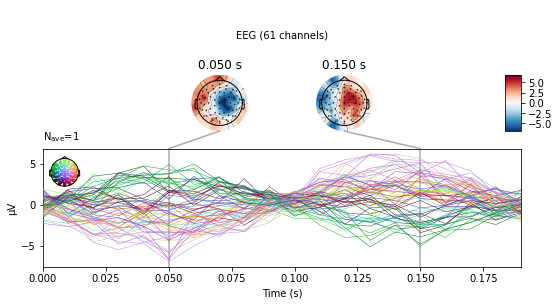

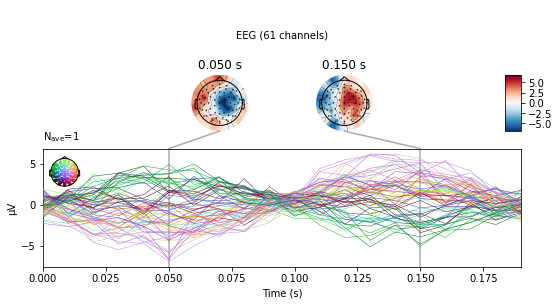

In [172]:
sim.source_data[0].plot(**plot_params)
sim.eeg_data[0].average().plot_joint()

## Build models

In [188]:
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Conv2D, Reshape, Flatten, BatchNormalization, concatenate, GRU, SimpleRNN
from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')
n_channels, n_dipoles = leadfield.shape

loss = "huber"  # tf.keras.losses.CosineSimilarity()
n_dense_units = 300
n_lstm_units = 150
activation_function = "tanh"
epochs = 30
batch_size = 32

#=========================================================#
# FC
# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# fc1 = TimeDistributed(Dense(n_dense_units, 
#             activation=activation_function), 
#             name='FC1')(inputs)
# out = TimeDistributed(Dense(n_dipoles, activation="linear"))(fc1)

# model1 = tf.keras.Model(inputs=inputs, outputs=out, name='FC')

# model1.compile(loss=loss, optimizer="adam")
# model1.summary()
# model1.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)


#=========================================================#
# LSTM
# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# fc1 = Bidirectional(LSTM(n_lstm_units, return_sequences=True, name='LSTM1'))(inputs)
# # fc1 = LSTM(n_lstm_units, return_sequences=False, name='LSTM2')(fc1)

# out = TimeDistributed(Dense(n_dipoles, activation="linear"))(fc1)
# # out = LSTM(n_dipoles, return_sequences=True, name='LSTM2')(fc1)


# model2 = tf.keras.Model(inputs=inputs, outputs=out, name='LSTM')
# model2.compile(loss=loss, optimizer="adam")
# model2.summary()
# model2.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# LSTM Context
inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, name='FC1'))(inputs)
# fc1 = LSTM(n_lstm_units, return_sequences=False, name='LSTM2')(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, activation="linear"))(fc1)

fc2 = Bidirectional(LSTM(n_lstm_units, return_sequences=True, name='LSTM1'))(fc1)
mask = TimeDistributed(Dense(n_dipoles, activation="tanh"))(fc2)

out = multiply([mask, direct_out])




# out = LSTM(n_dipoles, return_sequences=True, name='LSTM2')(fc1)


model2 = tf.keras.Model(inputs=inputs, outputs=out, name='LSTM_Context')
model2.compile(loss=loss, optimizer="adam")
model2.summary()
model2.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

#=========================================================#
# Encoder-Decoder

# inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
# encoder_outputs, state_h, state_c = LSTM(n_lstm_units, return_state=True)(inputs)

# decoder_LSTM = LSTM(n_lstm_units, return_state=True, return_sequences=True)   
# decoder_outputs, _, _ = decoder_LSTM(inputs, initial_state=[state_h, state_c])


# outputs = Dense(n_dipoles, activation='linear')(decoder_outputs)

# model3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='Encoder-Decoder')

# model3.compile(loss=loss, optimizer="adam")
# model3.summary()
# model3.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)


Model: "LSTM_Context"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 61)]   0           []                               
                                                                                                  
 time_distributed_22 (TimeDistr  (None, None, 300)   18600       ['Input[0][0]']                  
 ibuted)                                                                                          
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, None, 300)   541200      ['time_distributed_22[0][0]']    
 l)                                                                                               
                                                                                       

## Test

In [191]:
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=1, beta_noise=(0,2), target_snr=2, source_time_course="pulse")

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=2)
X_test, y_test = prep_data(sim_test)
stc = sim_test.source_data[0]
stc.plot(**plot_params)

models = [model1, model2, model3]
for model in models:
    y_pred = model.predict(X_test)
    stc_ = stc.copy()
    stc_.data = y_pred[0].T
    stc_.plot(**plot_params, brain_kwargs=dict(title=model.name))
    mse = np.mean((y_pred-y_test)**2)
    print(model.name, ": ", mse)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 60.77it/s]


FC :  0.0014893356127946083
LSTM_Context :  0.0009897464425369642
Encoder-Decoder :  0.001383276956190837


Using control points [0.05300562 0.06707293 0.11766742]
Using control points [0.08312639 0.10161218 0.77663031]
Using control points [0.05300562 0.06707293 0.11766742]
Using control points [0.08312639 0.10161218 0.77663031]
Using control points [0.00000000e+00 0.00000000e+00 2.00472014e-08]


# Architectures

In [79]:
loss = "huber"
# loss = tf.keras.losses.CosineSimilarity()

## LSTM SINGLE-PATH

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, add, Activation, Dropout, concatenate
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 32
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2
input_dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')


fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(fc1)

# Masking
lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM1')(fc1)
mask = TimeDistributed(Dense(n_dipoles, 
            activation="sigmoid"), 
            name='Mask')(lstm1)

multi = multiply([direct_out, mask], name="multiply")
model = tf.keras.Model(inputs=inputs, outputs=multi, name='Contextualizer')
model.add_loss(K.mean(K.abs(mask))*1e-2)

model.compile(loss=loss, optimizer="adam")
model.summary()
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "Contextualizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 61)]   0           []                               
                                                                                                  
 FC1 (TimeDistributed)          (None, None, 300)    18600       ['Input[0][0]']                  
                                                                                                  
 dropout_11 (Dropout)           (None, None, 300)    0           ['FC1[0][0]']                    
                                                                                                  
 LSTM1 (Bidirectional)          (None, None, 64)     64128       ['dropout_11[0][0]']             
                                                                                     

In [90]:
n_samples = 200
# settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
settings_alt = dict(duration_of_trial=0.20, extents=(1, 40), number_of_sources=(1,15), target_snr=(1, 15))


sim_test = Simulation(fwd, info, settings=settings_alt).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

error = model.evaluate(X_test, y_test, verbose=0)
print(f"error: {error}")
y_hat = model.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)


Simulating data based on sparse patches.


100%|██████████| 200/200 [00:03<00:00, 59.96it/s]


1
error: 0.010041557252407074


Using control points [0.32916539 0.38581702 0.54196449]
Using control points [0.56020409 0.6503592  0.97683875]
Using control points [4.31681776e-14 2.72470626e-13 1.12558118e-11]
Using control points [0.07107591 0.0752193  0.1097129 ]
Using control points [0.30229189 0.37536541 0.54561051]
Using control points [0.64646505 0.78543492 1.11528787]
Using control points [0.64646505 0.78543492 1.11528787]
Using control points [0.68535402 0.84364348 1.24558203]
Using control points [0.70009242 0.84312491 1.22084468]
Using control points [0.79759048 0.95056859 1.38809427]


## LSTM DOUBLE-PATH

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, add, Activation, Dropout, concatenate
from tensorflow.keras.regularizers import l1
from esinet.losses import nmse_loss, nmae_loss

leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, _ = leadfield.shape
n_dipoles = y.shape[-1]
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 61
n_lstm_units = 32
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2
input_dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

fc0 = TimeDistributed(Dense(n_channels, 
            activation=activation_function), 
            name='FC0')(inputs)
fc0 = Dropout(dropout)(fc0)

# Context
lstm0 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM0')(fc0)
cat = concatenate([lstm0, fc0])

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(cat)
fc1 = Dropout(dropout)(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(fc1)




# Masking
lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM1')(fc1)
mask = TimeDistributed(Dense(n_dipoles, 
            activation="sigmoid"), 
            name='Mask')(lstm1)

multi = multiply([direct_out, mask], name="multiply")
model = tf.keras.Model(inputs=inputs, outputs=multi, name='Contextualizer')
model.add_loss(K.mean(K.abs(mask))*1e-2)


model.compile(loss=loss, optimizer="adam")
model.summary()
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "Contextualizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 61)]   0           []                               
                                                                                                  
 FC0 (TimeDistributed)          (None, None, 61)     3782        ['Input[0][0]']                  
                                                                                                  
 dropout_3 (Dropout)            (None, None, 61)     0           ['FC0[0][0]']                    
                                                                                                  
 LSTM0 (Bidirectional)          (None, None, 64)     18240       ['dropout_3[0][0]']              
                                                                                     

In [31]:
n_samples = 200
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

error = model.evaluate(X_test, y_test, verbose=0)
print(f"error: {error}")
y_hat = model.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)

Simulating data based on sparse patches.


100%|██████████| 200/200 [00:02<00:00, 71.27it/s]


5
error: 0.002569999312981963


Using control points [3.02116368e-09 2.67798996e-08 3.51250970e-08]
Using control points [8.25629933e-05 1.09109362e-04 6.67372005e-04]
Using control points [3.02116368e-09 2.67798996e-08 3.51250970e-08]


## LSTM Encoder-Decoder

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, add, Activation, Dropout, concatenate
from tensorflow.keras.regularizers import l1
from esinet.losses import nmse_loss, nmae_loss

leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, _ = leadfield.shape
n_dipoles = y.shape[-1]
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')


n_dense_units = 61
n_lstm_units = 128
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2
input_dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
encoder_outputs, state_h, state_c = LSTM(n_lstm_units, return_state=True)(inputs)

decoder_LSTM = LSTM(n_lstm_units, return_state=True, return_sequences=True)   
decoder_outputs, _, _ = decoder_LSTM(inputs, initial_state=[state_h, state_c])
outputs = TimeDistributed(Dense(n_dipoles, activation='linear'))(decoder_outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Encoder-Decoder')
model.compile(loss=loss, optimizer="adam")
model.summary()
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "Encoder-Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 61)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        97280       ['Input[0][0]']                  
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 128),  97280       ['Input[0][0]',                  
                                 (None, 128),                     'lstm[0][1]',     

In [33]:
n_samples = 200
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

error = model.evaluate(X_test, y_test, verbose=0)
print(f"error: {error}")
y_hat = model.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)


Simulating data based on sparse patches.


100%|██████████| 200/200 [00:02<00:00, 68.97it/s]


3
error: 0.002369122812524438


Using control points [0.03084668 0.03540283 0.06492488]
Using control points [7.83109839e-15 2.70473606e-12 1.32622130e-08]
Using control points [7.83109839e-15 2.70473606e-12 1.32622130e-08]
Using control points [3.53347129e-15 1.22040444e-12 9.49015868e-09]
Using control points [4.87417981e-16 1.68346370e-13 3.16518037e-08]
Using control points [0.04085439 0.0593598  0.11993631]
Using control points [1.15491897e-15 3.98890530e-13 3.31839426e-08]
Using control points [0.04770753 0.06768148 0.13079534]


## Old LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 128
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)
lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, name='LSTM1'))(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(lstm1)


model2 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='LSTM_Old')


model2.compile(loss=loss, optimizer="adam")
model2.summary()
model2.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

# FC

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 30
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="tanh"),
            name='FC2')(fc1)


model3 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='FC')
model3.add_loss(K.mean(K.abs(direct_out))*1e-2)


model3.compile(loss=loss, optimizer="adam")

model3.summary()
model3.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 61)]        0         
                                                                 
 FC1 (TimeDistributed)       (None, None, 300)         18600     
                                                                 
 FC2 (TimeDistributed)       (None, None, 1284)        386484    
                                                                 
 tf.math.abs_17 (TFOpLambda)  (None, None, 1284)       0         
                                                                 
 tf.math.reduce_mean_17 (TFO  ()                       0         
 pLambda)                                                        
                                                                 
 tf.math.multiply_16 (TFOpLa  ()                       0         
 mbda)                                                          

In [85]:
n_samples = 200
settings_alt = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=(1,15))

sim_test = Simulation(fwd, info, settings=settings_alt).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

error = model3.evaluate(X_test, y_test, verbose=0)
print(f"error: {error}")
y_hat = model3.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)


Simulating data based on sparse patches.


100%|██████████| 200/200 [00:03<00:00, 50.48it/s]


3
error: 0.010495411232113838


# CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, Conv2D, Flatten, Reshape

from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
n_time = X.shape[1]
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 100
n_lstm_units = 30
activation_function = "tanh"
batch_size = 32
epochs = 200
dropout = 0.1
n_filters = int(n_channels / 2)
kernel_size = (1, n_dipoles)
dilation_rate = (2, 1)
new_shape = (n_time, n_dipoles, 1)

inputs = tf.keras.Input(shape=(X.shape[1], n_channels), name='Input')
# cnn = Conv2D(n_filters, kernel_size, dilation_rate=dilation_rate, padding="valid")(inputs)
# cnn = Reshape(new_shape)(cnn)


fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)

cnn = Reshape((n_time, n_dense_units, 1))(fc1)
cnn = Conv2D(n_filters, (3, 100), dilation_rate=dilation_rate, padding="same", activation=activation_function)(cnn)
cnn = Reshape((n_time, n_filters*n_dense_units))(cnn)

fc2 = TimeDistributed(Dense(300, 
            activation=activation_function),
            name='FC2')(cnn)

fc3 = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC3')(fc2)

# cnn = Reshape(new_shape)(cnn)


model4 = tf.keras.Model(inputs=inputs, outputs=fc3, name='FC-CNN')


model4.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")

model4.summary()
model4.fit(X[:, :, :, np.newaxis], y[:, :, :, np.newaxis], epochs=epochs, batch_size=batch_size, validation_split=0.15)

In [ ]:
n_samples = 2
settings = dict(duration_of_trial=0.2, extents=(1,40), number_of_sources=3, target_snr=(2, 15))

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

y_hat = model4.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)


# FC - context

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, Conv2D, Flatten, Reshape, Dropout, concatenate, RepeatVector
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss

leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
n_time = X.shape[1]
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 30
n_embed = 200
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.1
n_filters = int(n_channels / 2)
kernel_size = (1, n_dipoles)
dilation_rate = (2, 1)
new_shape = (n_time, n_embed)

inputs = tf.keras.Input(shape=(X.shape[1], n_channels), name='Input')

context = Flatten()(inputs)
context = Dense(n_embed, activation=activation_function, name="context")(context)
# context = Reshape(new_shape)(context)
context = RepeatVector(n_time)(context)

context = concatenate([inputs, context])
# context = Dropout(0.2)(context)

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(context)
# cat = concatenate([fc1, context])

fc2 = TimeDistributed(Dense(n_dipoles, 
            activation="tanh"),
            name='FC2')(fc1)



model5 = tf.keras.Model(inputs=inputs, outputs=fc2, name='FC-Context')
model5.add_loss(K.mean(K.abs(fc2)) * 1e-2)

model5.compile(loss=loss, optimizer="adam")

model5.summary()
model5.fit(X[:, :, :, np.newaxis], y[:, :, :, np.newaxis], epochs=epochs, batch_size=batch_size, validation_split=0.15)
# model5.fit(generate_batches(batch_size), steps_per_epoch=1000, epochs=epochs, batch_size=batch_size)

Model: "FC-Context"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 20, 61)]     0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 1220)         0           ['Input[0][0]']                  
                                                                                                  
 context (Dense)                (None, 200)          244200      ['flatten_2[0][0]']              
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 20, 200)     0           ['context[0][0]']                
                                                                                         

In [41]:
n_samples = 200
settings = dict(duration_of_trial=0.20, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

error = model5.evaluate(X_test, y_test, verbose=0)
print(f"error: {error}")
y_hat = model5.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)


Simulating data based on sparse patches.


100%|██████████| 200/200 [00:03<00:00, 58.83it/s]


1
error: 0.002958708442747593


Using control points [0.02553031 0.02805882 0.03966862]
Using control points [0.00000000e+00 3.59008654e-09 1.90625137e-08]


# Eval

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys; sys.path.insert(0, '../../invert/')
from invert.solvers.empirical_bayes import SolverChampagne

solver = SolverChampagne()
solver.make_inverse_operator(fwd)
n_samples = 2
settings = dict(duration_of_trial=0.2, number_of_sources=(1,10), extents=(1,40))
# settings = dict(duration_of_trial=0.25, number_of_sources=5, extents=(1,2))

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X_test, y_test = prep_data(sim_test)

# models = [model, model2, model3]
# aucs = []
# mles = []
# nmses = []
# for net in models:
#     y_hat = net.predict(X_test)
#     auc, nmse, mle = eval(y_test, y_hat)
#     aucs.append( auc )
#     nmses.append( nmse )
#     mles.append( mle )
#     print(f"{net.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

# y_hat = np.stack([solver.apply_inverse_operator(epochs.average()).data for epochs in tqdm(sim_test.eeg_data)], axis=0)
# y_hat = np.swapaxes(y_hat, 1, 2)
# auc, nmse, mle = eval(y_test, y_hat)
# aucs.append( auc )
# nmses.append( nmse )
# mles.append( mle )

# models.append(solver)
# print(f"{solver.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

idx = 0
n = sim_test.simulation_info["number_of_sources"].values[idx]
print(f"{n} sources")

# PLOTTING BRAINS
stc = sim_test.source_data[idx]
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"))

stc_hat = stc.copy()
y_hat = model5.predict(X_test)[idx]
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model5.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model5.name}: r={r:.2f}")


# y_hat = model2.predict(X_test)[idx]
# stc_hat = stc.copy()
# stc_hat.data = y_hat.T
# stc_hat.plot(**plot_params, brain_kwargs=dict(title=model2.name))
# r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
# print(f"{model2.name}: r={r:.2f}")

# y_hat = model3.predict(X_test)[idx]
# stc_hat = stc.copy()
# stc_hat.data = y_hat.T
# stc_hat.plot(**plot_params, brain_kwargs=dict(title=model3.name))
# r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
# print(f"{model3.name}: r={r:.2f}")


# evoked = sim_test.eeg_data[idx].average()
# stc_hat = solver.apply_inverse_operator(evoked)
# stc_hat.plot(**plot_params, brain_kwargs=dict(title=solver.name))
# y_hat = stc_hat.data
# r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
# print(f"{solver.name}: r={r:.2f}")


In [ ]:
import seaborn as sns
names = [m.name for m in models]
xticks = (np.arange(len(models)), names)

plt.figure()
sns.boxplot(data=np.nanmean(aucs,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("AUC")
plt.title("AUC")

plt.figure()
sns.boxplot(data=np.nanmean(mles,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("MLE")
plt.title("MLE")

plt.figure()
sns.boxplot(data=np.nanmean(nmses,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("NMSE")
plt.title("NMSE")
